step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

amount - amount of the transaction in local currency.

nameOrig - customer who started the transaction

oldbalanceOrg - initial balance before the transaction

newbalanceOrig - new balance after the transaction

nameDest - customer who is the recipient of the transaction

oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

https://www.kaggle.com/arjunjoshua/predicting-fraud-in-financial-payment-services

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io
import os
import sys
import time
import json
from IPython.display import display
from time import strftime, gmtime
import sagemaker
from sagemaker.predictor import csv_serializer
import pandas as pd

In [55]:
rawdata_df = pd.read_csv("PS_20174392719_1491204439457_log.csv")

#### EXPLORE RAW DATA

In [56]:
#Verifying the shape, rows and columns of the data frame
rawdata_df.shape

(6362620, 11)

In [57]:
#Verifying the column header
rawdata_df.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

In [58]:
#view the first five rows of the data frame to verify import
rawdata_df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


#### Feature Engineering

In [59]:
#Removing varaibles that we didn't think would contribute to the model
df_unused_col_removed = rawdata_df.drop(['nameOrig', 'nameDest', 'isFlaggedFraud'], axis=1)
df_unused_col_removed.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,1,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0,0
1,1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0,0
2,1,TRANSFER,181.00,181.0,0.00,0.0,0.0,1
3,1,CASH_OUT,181.00,181.0,0.00,21182.0,0.0,1
4,1,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0,0


In [60]:
#Using One Hot Enoding to transfor our categorical variable Types to dummy variables
df_w_dummies = pd.get_dummies(df_unused_col_removed, columns=['type'])
df_w_dummies.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,9839.64,170136.0,160296.36,0.0,0.0,0,0,0,0,1,0
1,1,1864.28,21249.0,19384.72,0.0,0.0,0,0,0,0,1,0
2,1,181.00,181.0,0.00,0.0,0.0,1,0,0,0,0,1
3,1,181.00,181.0,0.00,21182.0,0.0,1,0,1,0,0,0
4,1,11668.14,41554.0,29885.86,0.0,0.0,0,0,0,0,1,0


In [61]:
from sklearn import preprocessing

#performing MinMax scalar to all variables - we understand that this doesn't make sense for variable "step"
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1), copy=True)
tmp_scaled_df = scaler.fit_transform(df_w_dummies)
scaled_df = pd.DataFrame(tmp_scaled_df)
scaled_df.head()

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


,0,1,2,3,4,5,6,7,8,9,10,11
0,0.0,0.000106,0.002855,0.003233,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.000020,0.000357,0.000391,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.000002,0.000003,0.000000,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.000002,0.000003,0.000000,0.000059,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.000126,0.000697,0.000603,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [62]:
#SageMaker expects the y (output/predictor) to be in the first column slot therefore, 
# moving that row 6 to first column of data frame

Y = scaled_df[6]

X = scaled_df.drop([6], axis=1)

finaldata = pd.concat([Y,X], axis=1)

finaldata.head()

,6,0,1,2,3,4,5,7,8,9,10,11
0,0.0,0.0,0.000106,0.002855,0.003233,0.000000,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.000020,0.000357,0.000391,0.000000,0.0,0.0,0.0,0.0,1.0,0.0
2,1.0,0.0,0.000002,0.000003,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,1.0
3,1.0,0.0,0.000002,0.000003,0.000000,0.000059,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,0.000126,0.000697,0.000603,0.000000,0.0,0.0,0.0,0.0,1.0,0.0


#### START THE MODEL STEP

In [63]:
import numpy as np

#Splitting data into train and validation and test (which will be used later as the hold out set)
train_data, validation_data, test_data = np.split(finaldata.sample(frac=1, random_state=1729), [int(0.7 * len(finaldata)), int(0.9 * len(finaldata))])
train_data.to_csv('train.csv', header=False, index=False)
validation_data.to_csv('validation.csv', header=False, index=False)

In [64]:
import boto3

#Defining variables
bucket = 'table1-aws-bankfraud'
prefix = 'sagemaker/DEMO-xgboost-churn'

#Putting csv files into s3
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train/train.csv')).upload_file('train.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'validation/validation.csv')).upload_file('validation.csv')

In [65]:
#Setting up the container
from sagemaker.amazon.amazon_estimator import get_image_uri
container = get_image_uri(boto3.Session().region_name, 'xgboost')

In [66]:
#Creating the train and validation channels
s3_input_train = sagemaker.s3_input(s3_data='s3://{}/{}/train'.format(bucket, prefix), content_type='csv')
s3_input_validation = sagemaker.s3_input(s3_data='s3://{}/{}/validation/'.format(bucket, prefix), content_type='csv')

In [67]:
#Setting up the XGBoost model and parameters to train the model with the train and validation data
sess = sagemaker.Session()
from sagemaker import get_execution_role
role = get_execution_role()

xgb = sagemaker.estimator.Estimator(container,
                                    role, 
                                    train_instance_count=1, 
                                    train_instance_type='ml.m4.xlarge',
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                    sagemaker_session=sess)
xgb.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        silent=0,
                        objective='binary:logistic',
                        num_round=100)

xgb.fit({'train': s3_input_train, 'validation': s3_input_validation}) 

2019-08-02 17:39:07 Starting - Starting the training job...
2019-08-02 17:39:09 Starting - Launching requested ML instances......
2019-08-02 17:40:12 Starting - Preparing the instances for training......
2019-08-02 17:41:13 Downloading - Downloading input data...
2019-08-02 17:42:04 Training - Training image download completed. Training in progress..
Arguments: train
[2019-08-02:17:42:05:INFO] Running standalone xgboost training.
[2019-08-02:17:42:05:INFO] File size need to be processed in the node: 663.51mb. Available memory size in the node: 8459.16mb
[2019-08-02:17:42:05:INFO] Determined delimiter of CSV input is ','
[17:42:05] S3DistributionType set as FullyReplicated
[17:42:08] 4453834x11 matrix with 48992174 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2019-08-02:17:42:08:INFO] Determined delimiter of CSV input is ','
[17:42:08] S3DistributionType set as FullyReplicated
[17:42:08] 1272524x11 matrix with 13997764 entries loaded from /opt/ml/i

[17:43:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 12 pruned nodes, max_depth=5
[40]#011train-error:0.000374#011validation-error:0.000374
[17:44:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 8 pruned nodes, max_depth=5
[41]#011train-error:0.000373#011validation-error:0.000374
[17:44:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 4 pruned nodes, max_depth=5
[42]#011train-error:0.000373#011validation-error:0.000371
[17:44:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 2 pruned nodes, max_depth=5
[43]#011train-error:0.000371#011validation-error:0.000372
[17:44:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[44]#011train-error:0.000369#011validation-error:0.000371
[17:44:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 6 pruned nodes, max_depth=5
[45]#011train-error:0.000368#011valid

[17:45:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 4 pruned nodes, max_depth=5
[86]#011train-error:0.000318#011validation-error:0.000332
[17:45:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 6 pruned nodes, max_depth=5
[87]#011train-error:0.000317#011validation-error:0.000332
[17:46:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 8 pruned nodes, max_depth=5
[88]#011train-error:0.000317#011validation-error:0.000328
[17:46:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 4 pruned nodes, max_depth=5
[89]#011train-error:0.000316#011validation-error:0.000326
[17:46:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 10 pruned nodes, max_depth=5
[90]#011train-error:0.000315#011validation-error:0.000324
[17:46:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 6 pruned nodes, max_depth=5
[91]#011train-error:0.000314#011valid

In [74]:
#Deploying the model to be used
xgb_predictor = xgb.deploy(initial_instance_count = 1, instance_type = 'ml.m4.xlarge')

--------------------------------------------------------------------------------------------------!

In [68]:
#Defining variables
xgb_predictor.content_type = 'text/csv'
xgb_predictor.serializer = csv_serializer
xgb_predictor.deserializer = None

In [ ]:
#Getting the endpoint name
xgb_predictor.endpoint

In [69]:
test_data.head()
test_data_new = test_data.drop([6],axis=1)
test_data_new.head()

,0,1,2,3,4,5,7,8,9,10,11
649918,0.045822,0.001434,0.000193,0.002905,0.000000,0.000000,1.0,0.0,0.0,0.0,0.0
6078014,0.696765,0.000064,0.000988,0.001067,0.000000,0.000000,0.0,0.0,0.0,1.0,0.0
3352247,0.339623,0.000031,0.000102,0.000064,0.002709,0.002716,0.0,1.0,0.0,0.0,0.0
2875453,0.304582,0.002093,0.000000,0.000000,0.000698,0.001240,0.0,1.0,0.0,0.0,0.0
5729113,0.536388,0.001007,0.001800,0.000286,0.000000,0.000261,0.0,1.0,0.0,0.0,0.0


,0,1,2,3,4,5,7,8,9,10,11
649918,0.045822,0.001434,0.000193,0.002905,0.000000,0.000000,1.0,0.0,0.0,0.0,0.0
6078014,0.696765,0.000064,0.000988,0.001067,0.000000,0.000000,0.0,0.0,0.0,1.0,0.0
3352247,0.339623,0.000031,0.000102,0.000064,0.002709,0.002716,0.0,1.0,0.0,0.0,0.0
2875453,0.304582,0.002093,0.000000,0.000000,0.000698,0.001240,0.0,1.0,0.0,0.0,0.0
5729113,0.536388,0.001007,0.001800,0.000286,0.000000,0.000261,0.0,1.0,0.0,0.0,0.0


In [71]:
def predict(data, rows=500):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        predictions = ','.join([predictions, xgb_predictor.predict(array).decode('utf-8')])

    return np.fromstring(predictions[1:], sep=',')

predictions = predict(test_data_new.as_matrix())

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:9: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [72]:
# pd.crosstab(index=test_data.iloc[:10000, 0], columns=np.round(predictions), rownames=['actual'], colnames=['predictions'])


pd.crosstab(np.round(test_data[6]), columns = np.where(predictions>0.3, 1, 0), rownames=['actual'], colnames=['predictions'])




predictions,0,1
actual,,
0.0,635396,39
1.0,178,649


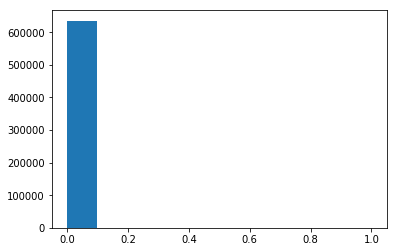

In [73]:
plt.hist(predictions)
plt.show()